# Data Visualization

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

df = pd.read_csv('data\data_test.csv', sep=';')

Text(0.5, 0.98, 'Dataset Distribution')

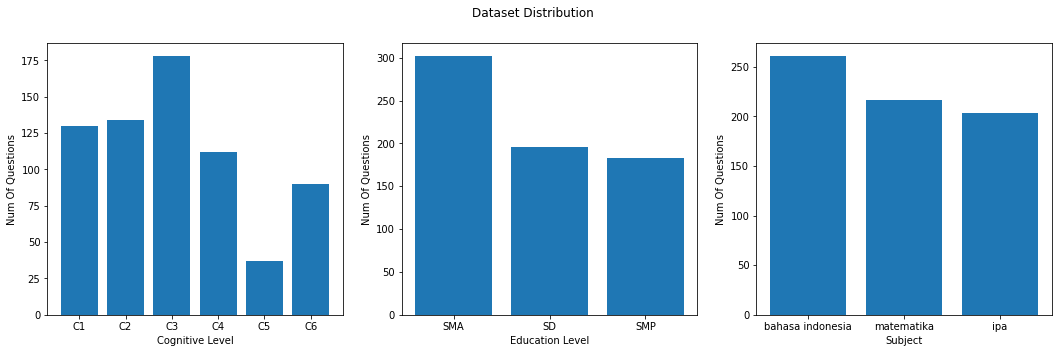

In [118]:
# Grafik kiri
label = df['label'].value_counts().sort_index(ascending=True)
label_pt = label.index
label_freq = label.values

# Grafik tengah
ed_level = df['edu_level'].value_counts()
edu_level_pt = ed_level.index
edu_level_freq = ed_level.values

# Grafik kanan
subject = df['subject'].value_counts()
subject_pt = subject.index
subject_freq = subject.values

# Subplot dibuat 1 baris, 3 kolom. figsize=(x, y)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Grafik kiri
axs[0].bar(label_pt, label_freq)
axs[0].set_xlabel("Cognitive Level")
axs[0].set_ylabel("Num Of Questions")

# Grafik tengah
axs[1].bar(edu_level_pt, edu_level_freq)
axs[1].set_xlabel("Education Level")
axs[1].set_ylabel("Num Of Questions")

# Grafik kanan
axs[2].bar(subject_pt, subject_freq)
axs[2].set_xlabel("Subject")
axs[2].set_ylabel("Num Of Questions")

fig.suptitle('Dataset Distribution')

#

## POS Tagging

In [3]:
from flair.data import Sentence
from flair.models import SequenceTagger
import re

# Loading trained model hasil dari FlairNLP untuk POS Tagging
postagger = SequenceTagger.load('resources/taggers/example-upos/best-model.pt')

D:\Coding\Software\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


2022-02-15 11:18:48,024 loading file resources/taggers/example-upos/best-model.pt


In [4]:
def add_tag(series):
    word_tag = []
    for i in range(series.shape[0]):
        text = Sentence(series[i])
        postagger.predict(text)
        
        # hasil dari FlairNLP berbentuk [WORD, <TAG>]
        # karakter kurung sudut dihilangkan
        x = re.split(r"\>\s|>", text.to_tagged_string())
        res = []
        
        # Untuk split biar dapet pasangan kata-tag
        for i in range(len(x)):
            temp = re.split(r"\s", x[i])
            if(len(temp) > 1):
                for char in temp[1]:
                    if char == '<':
                        temp[1] = temp[1].replace('<', "")
                res.append(temp)
        word_tag.append(res)
    
    return word_tag

In [5]:
df['tag_pair'] = add_tag(df.question)
df.head()

,text,question,label,subject,edu_level,tag_pair
0,"Udang ronggeng memiliki duri-duri yang keras, ...",Makna istilah kata vulkanis pada kutipan teks ...,C2,bahasa indonesia,SMA,"[[Makna, NOUN], [istilah, NOUN], [kata, NOUN],..."
1,Saya pun membandingkan perlakuan yang ibu beri...,Latar suasana pada paragraf pertama dalam kuti...,C2,bahasa indonesia,SMA,"[[Latar, NOUN], [suasana, NOUN], [pada, ADP], ..."
2,Bapakku bernama Narto. Biasa dipanggil Kang Na...,Makna frasa cokelat legam pada kutipan cerpen ...,C2,bahasa indonesia,SMA,"[[Makna, NOUN], [frasa, NOUN], [cokelat, NOUN]..."
3,Kebakaran hutan akibat kelalaian manusia di be...,Maksud pernyataan Evakuasi akan dilakukan kepa...,C2,bahasa indonesia,SMA,"[[Maksud, NOUN], [pernyataan, NOUN], [Evakuasi..."
4,Hal yang disarankan Mat agar dilakukan istriny...,Nilai moral pada kutipan novel tersebut adalah ….,C2,bahasa indonesia,SMA,"[[Nilai, NOUN], [moral, NOUN], [pada, ADP], [k..."


#

## Preprocessing

In [6]:
def print_full(df, num):
    for i in range(num):
        print(df[i])
        print("")

### Casefolding

In [7]:
# Casefolding from column 'question'
# df.question = df.question.str.lower()

# Mengubah semua huruf kapital menjadi huruf kecil dari kolom 'tag_pair'
for i in range(df.tag_pair.shape[0]):
    for j in range(len(df['tag_pair'][i])):
        df['tag_pair'][i][j][0] = df['tag_pair'][i][j][0].lower()
        
print_full(df.tag_pair, 5)

[['makna', 'NOUN'], ['istilah', 'NOUN'], ['kata', 'NOUN'], ['vulkanis', 'NOUN'], ['pada', 'ADP'], ['kutipan', 'NOUN'], ['teks', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX'], ['…', 'PUNCT'], ['.', 'PUNCT']]

[['latar', 'NOUN'], ['suasana', 'NOUN'], ['pada', 'ADP'], ['paragraf', 'NOUN'], ['pertama', 'ADJ'], ['dalam', 'ADP'], ['kutipan', 'NOUN'], ['cerpen', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX'], ['…', 'PUNCT'], ['.', 'PUNCT']]

[['makna', 'NOUN'], ['frasa', 'NOUN'], ['cokelat', 'NOUN'], ['legam', 'ADJ'], ['pada', 'ADP'], ['kutipan', 'NOUN'], ['cerpen', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX'], ['…', 'PUNCT'], ['.', 'PUNCT']]

[['maksud', 'NOUN'], ['pernyataan', 'NOUN'], ['evakuasi', 'NOUN'], ['akan', 'AUX'], ['dilakukan', 'VERB'], ['kepada', 'ADP'], ['masyarakat', 'NOUN'], ['yang', 'PRON'], ['daerahnya', 'NOUN'], ['telah', 'AUX'], ['dipenuhi', 'VERB'], ['kabut', 'NOUN'], ['asap', 'NOUN'], ['akibat', 'ADP'], ['kebakaran', 'NOUN'], ['hutan', 'NOUN'], ['pada', 'ADP'], ['p

### Punctuation Removal

In [8]:
import string

In [9]:
def remove_punctuation(series):
    no_punct = []
    for i in range(series.shape[0]):
        holder = series[i]
        temp = []
        for j in range(len(holder)):
        
            # Mapping punctuations dari string ke ''
            holder[j][0] = holder[j][0].translate(str.maketrans('', '', string.punctuation))

            # Hapus tag bertanda 'PUNCT'
            # Dibuat list baru untuk nampung non-PUNCT
            if len(holder[j][0]) > 0 and holder[j][1] != 'PUNCT':
                temp.append(holder[j])
        
        no_punct.append(temp)
    return no_punct

In [10]:
df['tag_pair'] = remove_punctuation(df['tag_pair'])

In [11]:
print_full(df.tag_pair, 5)

[['makna', 'NOUN'], ['istilah', 'NOUN'], ['kata', 'NOUN'], ['vulkanis', 'NOUN'], ['pada', 'ADP'], ['kutipan', 'NOUN'], ['teks', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX']]

[['latar', 'NOUN'], ['suasana', 'NOUN'], ['pada', 'ADP'], ['paragraf', 'NOUN'], ['pertama', 'ADJ'], ['dalam', 'ADP'], ['kutipan', 'NOUN'], ['cerpen', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX']]

[['makna', 'NOUN'], ['frasa', 'NOUN'], ['cokelat', 'NOUN'], ['legam', 'ADJ'], ['pada', 'ADP'], ['kutipan', 'NOUN'], ['cerpen', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX']]

[['maksud', 'NOUN'], ['pernyataan', 'NOUN'], ['evakuasi', 'NOUN'], ['akan', 'AUX'], ['dilakukan', 'VERB'], ['kepada', 'ADP'], ['masyarakat', 'NOUN'], ['yang', 'PRON'], ['daerahnya', 'NOUN'], ['telah', 'AUX'], ['dipenuhi', 'VERB'], ['kabut', 'NOUN'], ['asap', 'NOUN'], ['akibat', 'ADP'], ['kebakaran', 'NOUN'], ['hutan', 'NOUN'], ['pada', 'ADP'], ['paragraf', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX']]

[['nilai', 'NOUN'], ['moral', 'NOUN'

### Stopword Removal

In [12]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# Bikin copy isi dataframe
# Work-around karena value setelah pake df.copy() suka berubah sendiri
def reserve(df_col):
    res = []
    for index in df_col.index:
        holder = df_col[index]
        temp = []
        for i in range(len(holder)):
            temp_2 = []
            temp_2.append(holder[i][0])
            temp_2.append(holder[i][1])
            temp.append(temp_2)
        res.append(temp)
    return res

In [14]:
# tambah 0 ke list reserve untuk keperluan weighting
def add_zero(list_2d):
    for i in range(len(list_2d)):
        for j in range(len(list_2d[i])):
            list_2d[i][j].append(0)
    return list_2d

In [15]:
def count_freq(corpus):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names_out()
    features_with_0 = []
    
    for i in range(len(features)):
        temp = []
        temp.append(features[i])
        temp.append(0)
        features_with_0.append(temp)

    wordfreq = X.toarray()
    for i in range(len(wordfreq)):
        for j in range(len(wordfreq[i])):
            if wordfreq[i][j] != 0:
                features_with_0[j][1] += wordfreq[i][j]
    
    return features_with_0

In [16]:
def remove_stopword(series, stopwords):
    res = []
    for i in range(series.shape[0]):
        temp = []
        holder = series[i]
        for j in range(len(holder)):
            if holder[j][0] in stopwords:
                holder[j][0] = ''
            if len(holder[j][0]) != 0:
                temp.append(holder[j])
        res.append(temp)
    return res

In [17]:
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.create_stop_word_remover()

In [18]:
sw_default = stopword_factory.get_stop_words()

sw_keep = ['adalah', 'apa', 'arti', 'artinya', 'berapa', 'berapakah', 'beri', 
           'berikan', 'diantaranya', 'disebut', 'jelaskan', 'karena',  
           'mengapa', 'menunjukkan', 'merupakan', 'rupa', 'sebut']

# List Comprehension buat exclude stopwords di sw_keep dari sw
sw_modify = [x for x in sw_default if x not in sw_keep]

In [19]:
# Duplikat kolom tag_pair
reserve_pair = reserve(df['tag_pair'])

In [20]:
# tag_pair di-assign reserve soalnya habis buang stopword jadi rusak
df['tag_pair_def'] = remove_stopword(df['tag_pair'], sw_default)
df['tag_pair'] = reserve_pair
print(df['tag_pair'][0])

[['makna', 'NOUN'], ['istilah', 'NOUN'], ['kata', 'NOUN'], ['vulkanis', 'NOUN'], ['pada', 'ADP'], ['kutipan', 'NOUN'], ['teks', 'NOUN'], ['tersebut', 'DET'], ['adalah', 'AUX']]


In [21]:
# Hapus stopwords dari tag_pair_mod
df['tag_pair_mod'] = remove_stopword(df['tag_pair'], sw_modify)

In [22]:
df['tag_pair_def'][0]

[['makna', 'NOUN'],
 ['istilah', 'NOUN'],
 ['vulkanis', 'NOUN'],
 ['kutipan', 'NOUN'],
 ['teks', 'NOUN']]

In [23]:
df['tag_pair_mod'][0]

[['makna', 'NOUN'],
 ['istilah', 'NOUN'],
 ['vulkanis', 'NOUN'],
 ['kutipan', 'NOUN'],
 ['teks', 'NOUN'],
 ['adalah', 'AUX']]

### Stemming

In [24]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Mengubah kata ke bentuk dasarnya
# Stemming setelah POSTagging karena sequence kata berguna dalam POSTagging
def stem(series):
    for i in range(series.shape[0]):
        holder = series[i]
        for j in range(len(holder)):
            holder[j][0] = stemmer.stem(holder[j][0])
    
    return series

In [25]:
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

In [26]:
df.tag_pair_def = stem(df.tag_pair_def)
df.tag_pair_def[0]

[['makna', 'NOUN'],
 ['istilah', 'NOUN'],
 ['vulkanis', 'NOUN'],
 ['kutip', 'NOUN'],
 ['teks', 'NOUN']]

In [27]:
df.tag_pair_mod = stem(df.tag_pair_mod)
df.tag_pair_mod[0]

[['makna', 'NOUN'],
 ['istilah', 'NOUN'],
 ['vulkanis', 'NOUN'],
 ['kutip', 'NOUN'],
 ['teks', 'NOUN'],
 ['adalah', 'AUX']]

# Feature Extraction

### Preparation
for TF-IDF

In [28]:
def to_corpus(series):
    corpus = []
    for i in range(series.shape[0]):
        holder = series[i]
        temp = []
        for j in range(len(holder)):
            temp.append(holder[j][0])
        corpus.append(' '.join(temp))
    return corpus

In [29]:
# Bikin corpus dari tag_pair_def & tag_pair_mod
corpus_def = to_corpus(df.tag_pair_def)
corpus_mod = to_corpus(df.tag_pair_mod)

In [30]:
corpus_def[0]

'makna istilah vulkanis kutip teks'

### TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import chain
import numpy as np

In [32]:
def flatten(term_doc_matrix):
    # Convert sparse matrix to list
    temp = []
    for i in range(term_doc_matrix.shape[0]):
        holder = term_doc_matrix[i].toarray().tolist()
        temp.append(holder[0])
    
    return temp

In [33]:
vectorizer = TfidfVectorizer()

# Buat ngitung nilai TF-IDF dari tiap term
term_doc_matrix_def = vectorizer.fit_transform(corpus_def)
# vocabulary_def = vectorizer.get_feature_names()

term_doc_matrix_mod = vectorizer.fit_transform(corpus_mod)
# vocabulary_mod = vectorizer.get_feature_names()

# Convert hasil fit_transform dari sparse matrix ke list
tfidf_def = flatten(term_doc_matrix_def)
tfidf_mod = flatten(term_doc_matrix_mod)

# Diubah ke dataframe untuk training & testing model
df_tfidf_def = pd.DataFrame(tfidf_def)
df_tfidf_mod = pd.DataFrame(tfidf_mod)

In [34]:
a = tfidf_def[0]
for i in range(len(a)):
    if a[i] != 0:
        print(str(i) + "  " + str(a[i]))

576  0.5220918026519731
723  0.34983840731204346
792  0.465779484261717
1219  0.28288115601620895
1307  0.5550323972389433


### Preparation
For TFPOS-IDF

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing

In [36]:
def termdoc_weighting(termdoc, features, tag_pair):
    result = []
    for i in range(len(termdoc)):
        holder = termdoc[i]
        holder_pair = tag_pair[i]
        temp = []
        for j in range(len(holder)):
            if holder[j] != 0:
                term = features[j]
                weight = 1
                for k in range(len(holder_pair)):
                    if holder_pair[k][0] == term:
                        if holder_pair[k][1] == 'VERB':
                            weight = 5
                        elif holder_pair[k][1] == 'ADJ' or holder_pair[k][1] == 'NOUN':
                            weight = 3
                        else:
                            weight = 1
                temp.append(holder[j] * weight)
            else:
                temp.append(holder[j])
        result.append(temp)
    return result

In [37]:
def count_tfidf(termdoc_weighted, features, df):
    result = []
    for i in range(len(termdoc_weighted)):
        holder = termdoc_weighted[i]
        temp = []
        denom = sum(termdoc_weighted[i])
        for j in range(len(holder)):
            if holder[j] != 0:
                term = features[j]
                idf = df.loc[df['word'] == term].idf
                temp.append((holder[j]/denom) * (float(idf)))
            else:
                temp.append(holder[j])
        result.append(temp)
    return result

In [38]:
vectorizer = TfidfVectorizer()

# Ambil nilai IDF tiap kata dari corpus
term_doc_matrix_def = vectorizer.fit_transform(corpus_def)
df_idf_def = pd.DataFrame(vectorizer.idf_, columns=['idf'])
df_idf_def['word'] = vectorizer.get_feature_names()

# Ambil nilai IDF tiap kata dari corpus
term_doc_matrix_mod = vectorizer.fit_transform(corpus_mod)
df_idf_mod = pd.DataFrame(vectorizer.idf_, columns=['idf'])
df_idf_mod['word'] = vectorizer.get_feature_names()

D:\Coding\Software\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
cv = CountVectorizer()

# Bikin term-document matrix
X_def = cv.fit_transform(corpus_def)
features_def = cv.get_feature_names_out()
termdoc_def = X_def.toarray()

# Bikin term-document matrix
X_mod = cv.fit_transform(corpus_mod)
features_mod = cv.get_feature_names_out()
termdoc_mod = X_mod.toarray()

# dari term document dikali weightnya masing-masing
termdoc_weighted_def = termdoc_weighting(termdoc_def, features_def, df.tag_pair_def)
termdoc_weighted_mod = termdoc_weighting(termdoc_mod, features_mod, df.tag_pair_mod)

### TFPOS-IDF

In [40]:
# TFPOS-IDF
ctfidf_def = count_tfidf(termdoc_weighted_def, features_def, df_idf_def)
ctfidf_mod = count_tfidf(termdoc_weighted_mod, features_mod, df_idf_mod)

# Normalisasi pake L2-Norm
tfposidf_def = preprocessing.normalize(ctfidf_def, norm='l2').tolist()
tfposidf_mod = preprocessing.normalize(ctfidf_mod, norm='l2').tolist()

# Ubah list ke bentuk dataframe untuk training & testing
df_tfposidf_def = pd.DataFrame(tfposidf_def)
df_tfposidf_mod = pd.DataFrame(tfposidf_mod)

In [41]:
# Untuk contoh hasil
df.tag_pair_def[5]

[['teladan', 'NOUN'], ['tokoh', 'NOUN'], ['dasar', 'ADP'], ['kutip', 'NOUN']]

In [42]:
# Kalo hasil dari tfidfvectorizer, urutan yg ditampilin sesuai sama urutan kata di dokumen (head--tail)
print(term_doc_matrix_def[5])

  (0, 382)	0.40174814472318027
  (0, 1252)	0.520511110095638
  (0, 1220)	0.6373892379778402
  (0, 723)	0.40174814472318027


In [43]:
# Hasil countvectorizer, urutannya jadi kebalik dari kata di dokumen (tail--head)
print(X_def[5])

  (0, 723)	1
  (0, 1220)	1
  (0, 1252)	1
  (0, 382)	1


In [44]:
# Kalo countvectorizer dibikin toarray(), urutannya jadi alphabetical ngikutin method get_feature_names_out()
a = termdoc_def[5]
for i in range(len(a)):
    if a[i] != 0:
        print(str(i) + "  " + str(a[i]))

382  1
723  1
1220  1
1252  1


In [45]:
# Kalo tfidfvectorizer di-apply flatten(), urutannya jadi alphabetical ngikutin method get_feature_names_out()
a = tfidf_def[5]
for i in range(len(a)):
    if a[i] != 0:
        print(str(i) + "  " + str(a[i]))

382  0.40174814472318027
723  0.40174814472318027
1220  0.6373892379778402
1252  0.520511110095638


In [46]:
# Hasil count_tfidf() sebelum normalisasi L2
a = ctfidf_def[5]
for i in range(len(a)):
    if a[i] != 0:
        print(str(i) + "  " + str(a[i]))

382  0.43061538329752613
723  1.2918461498925784
1220  2.049564743185055
1252  1.6737358526364445


In [47]:
# Hasil TFPOS-IDF setelah normalisasi L2
a = tfposidf_def[5]
for i in range(len(a)):
    if a[i] != 0:
        print(str(i) + "  " + str(a[i]))

382  0.1446974390994958
723  0.4340923172984874
1220  0.6887045403173292
1252  0.5624167203477981


#

### Random Oversampling

In [48]:
from imblearn.over_sampling import RandomOverSampler

# Not majority karena cuma C3 yang banyak sendiri datanya
ros = RandomOverSampler(sampling_strategy = 'not majority', random_state = 10)

In [49]:
# Resampling dari TF-IDF Reguler
X_def, y_def = ros.fit_resample(tfidf_def, df['label'])
X_mod, y_mod = ros.fit_resample(tfidf_mod, df['label'])

df_tfidf_ros_def = pd.DataFrame(X_def)
tfidf_ros_label_def = pd.DataFrame(y_def)
df_tfidf_ros_mod = pd.DataFrame(X_mod)
tfidf_ros_label_mod = pd.DataFrame(y_mod)

# Resampling dari TFPOS-IDF
X_def, y_def = ros.fit_resample(tfposidf_def, df['label'])
X_mod, y_mod = ros.fit_resample(tfposidf_mod, df['label'])

df_tfposidf_ros_def = pd.DataFrame(X_def)
ros_tfposidf_label_def = pd.DataFrame(y_def)
df_tfposidf_ros_mod = pd.DataFrame(X_mod)
ros_tfposidf_label_mod = pd.DataFrame(y_mod)

In [50]:
tfidf_ros_label_def.value_counts()

label
C6       248
C5       248
C4       248
C3       248
C2       248
C1       248
dtype: int64

In [51]:
df.label.value_counts()

C3    248
C2    134
C1    130
C4    113
C5     37
C6     19
Name: label, dtype: int64

#

# Training & Testing

Skenario pengujian
1. TFIDF reguler, stopword PySastrawi ==> use df_tfidf_def
2. TFIDF reguler, stopword modifikasi PySastrawi ==> use df_tfidf_mod
3. TFIDF reguler, stopword PySastrawi, random over-sampling ==> df_tfidf_ros_def
4. TFIDF reguler, stopword modifikasi PySastrawi, random over-sampling ==> df_tfidf_ros_mod
5. TFPOS-IDF, stopword PySastrawi ==> use df_tfposidf_def
6. TFPOS-IDF, stopword modifikasi PySastrawi ==> df_tfposidf_mod
7. TFPOS-IDF, stopword PySastrawi, random over-sampling ==> df_tfposidf_ros_def
8. TFPOS-IDF, stopword modifikasi PySastrawi, random over-sampling ==> df_tfposidf_ros_mod

In [52]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [53]:
def get_score(test, pred):
    accuracy = metrics.accuracy_score(test, pred)
    precision = metrics.precision_score(test, pred, average='weighted')
    recall = metrics.recall_score(test, pred, average='weighted')
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

## Skenario 1 - SVM
TFIDF reguler, stopword PySastrawi ==> use df_tfidf_def

In [54]:
X_train_svm1, X_test_svm1, y_train_svm1, y_test_svm1 = train_test_split(df_tfidf_def, 
                                                                        df['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=23)
clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm1, y_train_svm1)
pred_svm_1 = clf_svm.predict(X_test_svm1)

accuracy, precision, recall, f1_score = get_score(y_test_svm1, pred_svm_1)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm1, y_train_svm1)

print(gs_svm.best_estimator_)

Accuracy:  0.453
Precision:  0.407
Recall:  0.453
F1 Score:  0.429
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=1000, gamma=0.001)


In [55]:
clf_svm = svm.SVC(C=1000, gamma = 0.001)
clf_svm.fit(X_train_svm1, y_train_svm1)
pred_svm_1 = clf_svm.predict(X_test_svm1)

accuracy, precision, recall, f1_score = get_score(y_test_svm1, pred_svm_1)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.445
Precision:  0.431
Recall:  0.445
F1 Score:  0.438


## Skenario 1 - NB
TFIDF reguler, stopword PySastrawi ==> use df_tfidf_def

In [56]:
X_train_nb1, X_test_nb1, y_train_nb1, y_test_nb1 = train_test_split(df_tfidf_def, 
                                                                    df['label'], 
                                                                    test_size=0.2, 
                                                                    random_state=23)
clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb1, y_train_nb1)
pred_nb_1 = clf_nb.predict(X_test_nb1)

accuracy, precision, recall, f1_score = get_score(y_test_nb1, pred_nb_1)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb1, y_train_nb1)

print(gs_nb.best_estimator_)

Accuracy:  0.423
Precision:  0.419
Recall:  0.423
F1 Score:  0.421
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.3)


In [57]:
clf_nb = MultinomialNB(alpha=0.3)
clf_nb.fit(X_train_nb1, y_train_nb1)
pred_nb_1 = clf_nb.predict(X_test_nb1)

accuracy, precision, recall, f1_score = get_score(y_test_nb1, pred_nb_1)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.445
Precision:  0.423
Recall:  0.445
F1 Score:  0.434


## Skenario 2 - SVM
TFIDF reguler, stopword modifikasi PySastrawi ==> use df_tfidf_mod

In [58]:
X_train_svm2, X_test_svm2, y_train_svm2, y_test_svm2 = train_test_split(df_tfidf_mod, 
                                                                        df['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm2, y_train_svm2)
pred_svm_2 = clf_svm.predict(X_test_svm2)

accuracy, precision, recall, f1_score = get_score(y_test_svm2, pred_svm_2)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm2, y_train_svm2)

print(gs_svm.best_estimator_)

Accuracy:  0.474
Precision:  0.432
Recall:  0.474
F1 Score:  0.452
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=100, gamma=0.01)


In [59]:
clf_svm = svm.SVC(C=100, gamma = 0.01)
clf_svm.fit(X_train_svm2, y_train_svm2)
pred_svm_2 = clf_svm.predict(X_test_svm2)

accuracy, precision, recall, f1_score = get_score(y_test_svm2, pred_svm_2)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.438
Precision:  0.43
Recall:  0.438
F1 Score:  0.434


## Skenario 2 - NB
TFIDF reguler, stopword modifikasi PySastrawi ==> use df_tfidf_mod

In [60]:
X_train_nb2, X_test_nb2, y_train_nb2, y_test_nb2 = train_test_split(df_tfidf_mod, 
                                                                    df['label'], 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb2, y_train_nb2)
pred_nb_2 = clf_nb.predict(X_test_nb2)

accuracy, precision, recall, f1_score = get_score(y_test_nb2, pred_nb_2)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb2, y_train_nb2)

print(gs_nb.best_estimator_)

Accuracy:  0.401
Precision:  0.443
Recall:  0.401
F1 Score:  0.421
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.1)


In [61]:
clf_nb = MultinomialNB(alpha=0.1)
clf_nb.fit(X_train_nb2, y_train_nb2)
pred_nb_2 = clf_nb.predict(X_test_nb2)

accuracy, precision, recall, f1_score = get_score(y_test_nb2, pred_nb_2)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.467
Precision:  0.491
Recall:  0.467
F1 Score:  0.479


## Skenario 3 - SVM
TFIDF reguler, stopword PySastrawi, random over-sampling  ==> df_tfidf_ros_def

In [62]:
X_train_svm3, X_test_svm3, y_train_svm3, y_test_svm3 = train_test_split(df_tfidf_ros_def, 
                                                                        tfidf_ros_label_def, 
                                                                        test_size=0.2, 
                                                                        random_state=23)
clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm3, y_train_svm3)
pred_svm_3 = clf_svm.predict(X_test_svm3)

accuracy, precision, recall, f1_score = get_score(y_test_svm3, pred_svm_3)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm3, y_train_svm3)

print(gs_svm.best_estimator_)

Accuracy:  0.799
Precision:  0.797
Recall:  0.799
F1 Score:  0.798
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=10, kernel='linear')


In [63]:
clf_svm = svm.SVC(C=10, kernel='linear')
clf_svm.fit(X_train_svm3, y_train_svm3)
pred_svm_3 = clf_svm.predict(X_test_svm3)

accuracy, precision, recall, f1_score = get_score(y_test_svm3, pred_svm_3)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.839
Precision:  0.836
Recall:  0.839
F1 Score:  0.837


## Skenario 3 - NB
TFIDF reguler, stopword PySastrawi, random over-sampling  ==> df_tfidf_ros_def

In [64]:
X_train_nb3, X_test_nb3, y_train_nb3, y_test_nb3 = train_test_split(df_tfidf_ros_def, 
                                                                    tfidf_ros_label_def, 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb3, y_train_nb3)
pred_nb_3 = clf_nb.predict(X_test_nb3)

accuracy, precision, recall, f1_score = get_score(y_test_nb3, pred_nb_3)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb3, y_train_nb3)

print(gs_nb.best_estimator_)

Accuracy:  0.772
Precision:  0.773
Recall:  0.772
F1 Score:  0.772
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.0)


In [65]:
clf_nb = MultinomialNB(alpha=0.0)
clf_nb.fit(X_train_nb3, y_train_nb3)
pred_nb_3 = clf_nb.predict(X_test_nb3)

accuracy, precision, recall, f1_score = get_score(y_test_nb3, pred_nb_3)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.815
Precision:  0.815
Recall:  0.815
F1 Score:  0.815


## Skenario 4 - SVM
TFIDF reguler, stopword modifikasi PySastrawi, random over-sampling  ==> df_tfidf_ros_mod

In [66]:
X_train_svm4, X_test_svm4, y_train_svm4, y_test_svm4 = train_test_split(df_tfidf_ros_mod, 
                                                                        tfidf_ros_label_mod, 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm4, y_train_svm4)
pred_svm_4 = clf_svm.predict(X_test_svm4)

accuracy, precision, recall, f1_score = get_score(y_test_svm4, pred_svm_4)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm4, y_train_svm4)

print(gs_svm.best_estimator_)

Accuracy:  0.819
Precision:  0.817
Recall:  0.819
F1 Score:  0.818
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=10, kernel='linear')


In [67]:
clf_svm = svm.SVC(C=10, kernel='linear')
clf_svm.fit(X_train_svm4, y_train_svm4)
pred_svm_4 = clf_svm.predict(X_test_svm4)

accuracy, precision, recall, f1_score = get_score(y_test_svm4, pred_svm_4)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.842
Precision:  0.841
Recall:  0.842
F1 Score:  0.842


## Skenario 4 - NB
TFIDF reguler, stopword modifikasi PySastrawi, random over-sampling  ==> df_tfidf_ros_mod

In [68]:
X_train_nb4, X_test_nb4, y_train_nb4, y_test_nb4 = train_test_split(df_tfidf_ros_mod, 
                                                                    tfidf_ros_label_mod, 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb4, y_train_nb4)
pred_nb_4 = clf_nb.predict(X_test_nb4)

accuracy, precision, recall, f1_score = get_score(y_test_nb4, pred_nb_4)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb4, y_train_nb4)

print(gs_nb.best_estimator_)

Accuracy:  0.782
Precision:  0.78
Recall:  0.782
F1 Score:  0.781
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.0)


In [69]:
clf_nb = MultinomialNB(alpha=0.0)
clf_nb.fit(X_train_nb4, y_train_nb4)
pred_nb_4 = clf_nb.predict(X_test_nb4)

accuracy, precision, recall, f1_score = get_score(y_test_nb4, pred_nb_4)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.829
Precision:  0.828
Recall:  0.829
F1 Score:  0.829


## Skenario 5 - SVM
TFPOS-IDF, stopword PySastrawi ==> use df_tfposidf_def

In [70]:
X_train_svm5, X_test_svm5, y_train_svm5, y_test_svm5 = train_test_split(df_tfposidf_def, 
                                                                        df['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm5, y_train_svm5)
pred_svm_5 = clf_svm.predict(X_test_svm5)

accuracy, precision, recall, f1_score = get_score(y_test_svm5, pred_svm_5)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm5, y_train_svm5)

print(gs_svm.best_estimator_)

Accuracy:  0.438
Precision:  0.423
Recall:  0.438
F1 Score:  0.43
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=1, kernel='linear')


In [71]:
clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm5, y_train_svm5)
pred_svm_5 = clf_svm.predict(X_test_svm5)

accuracy, precision, recall, f1_score = get_score(y_test_svm5, pred_svm_5)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.438
Precision:  0.423
Recall:  0.438
F1 Score:  0.43


## Skenario 5 - NB
TFPOS-IDF, stopword PySastrawi ==> use df_tfposidf_def

In [72]:
X_train_nb5, X_test_nb5, y_train_nb5, y_test_nb5 = train_test_split(df_tfposidf_def,
                                                                    df['label'], 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb5, y_train_nb5)
pred_nb_5 = clf_nb.predict(X_test_nb5)

accuracy, precision, recall, f1_score = get_score(y_test_nb5, pred_nb_5)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb5, y_train_nb5)

print(gs_nb.best_estimator_)

Accuracy:  0.431
Precision:  0.5
Recall:  0.431
F1 Score:  0.463
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.2)


In [73]:
clf_nb = MultinomialNB(alpha=0.2)
clf_nb.fit(X_train_nb5, y_train_nb5)
pred_nb_5 = clf_nb.predict(X_test_nb5)

accuracy, precision, recall, f1_score = get_score(y_test_nb5, pred_nb_5)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.453
Precision:  0.448
Recall:  0.453
F1 Score:  0.45


## Skenario 6 - SVM
TFPOS-IDF, stopword modifikasi PySastrawi ==> df_tfposidf_mod

In [74]:
X_train_svm6, X_test_svm6, y_train_svm6, y_test_svm6 = train_test_split(df_tfposidf_mod, 
                                                                        df['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm6, y_train_svm6)
pred_svm6 = clf_svm.predict(X_test_svm6)

accuracy, precision, recall, f1_score = get_score(y_test_svm6, pred_svm6)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm6, y_train_svm6)

print(gs_svm.best_estimator_)

Accuracy:  0.445
Precision:  0.417
Recall:  0.445
F1 Score:  0.431
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=1000, gamma='auto')


In [75]:
clf_svm = svm.SVC(C=1000, gamma='auto')
clf_svm.fit(X_train_svm6, y_train_svm6)
pred_svm6 = clf_svm.predict(X_test_svm6)

accuracy, precision, recall, f1_score = get_score(y_test_svm6, pred_svm6)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.504
Precision:  0.478
Recall:  0.504
F1 Score:  0.491


## Skenario 6 - NB
TFPOS-IDF, stopword modifikasi PySastrawi ==> df_tfposidf_mod

In [76]:
X_train_nb6, X_test_nb6, y_train_nb6, y_test_nb6 = train_test_split(df_tfposidf_mod, 
                                                                    df['label'], 
                                                                    test_size=0.2,
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb6, y_train_nb6)
pred_nb6 = clf_nb.predict(X_test_nb6)

accuracy, precision, recall, f1_score = get_score(y_test_nb6, pred_nb6)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb6, y_train_nb6)

print(gs_nb.best_estimator_)

Accuracy:  0.401
Precision:  0.463
Recall:  0.401
F1 Score:  0.43
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.1)


In [77]:
clf_nb = MultinomialNB(alpha=0.1)
clf_nb.fit(X_train_nb6, y_train_nb6)
pred_nb6 = clf_nb.predict(X_test_nb6)

accuracy, precision, recall, f1_score = get_score(y_test_nb6, pred_nb6)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.467
Precision:  0.477
Recall:  0.467
F1 Score:  0.472


## Skenario 7 - SVM
TFPOS-IDF, stopword PySastrawi, random over-sampling ==> df_tfposidf_ros_def

In [78]:
X_train_svm7, X_test_svm7, y_train_svm7, y_test_svm7 = train_test_split(df_tfposidf_ros_def, 
                                                                        ros_tfposidf_label_def, 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm7, y_train_svm7)
pred_svm_7 = clf_svm.predict(X_test_svm7)

accuracy, precision, recall, f1_score = get_score(y_test_svm7, pred_svm_7)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm7, y_train_svm7)

print(gs_svm.best_estimator_)

Accuracy:  0.815
Precision:  0.813
Recall:  0.815
F1 Score:  0.814
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=10, kernel='linear')


In [79]:
clf_svm = svm.SVC(C=10, kernel='linear')
clf_svm.fit(X_train_svm7, y_train_svm7)
pred_svm_7 = clf_svm.predict(X_test_svm7)

accuracy, precision, recall, f1_score = get_score(y_test_svm7, pred_svm_7)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.836
Precision:  0.836
Recall:  0.836
F1 Score:  0.836


## Skenario 7 - NB
TFPOS-IDF, stopword PySastrawi, random over-sampling ==> df_tfposidf_ros_def

In [80]:
X_train_nb7, X_test_nb7, y_train_nb7, y_test_nb7 = train_test_split(df_tfposidf_ros_def, 
                                                                    ros_tfposidf_label_def, 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb7, y_train_nb7)
pred_nb7 = clf_nb.predict(X_test_nb7)

accuracy, precision, recall, f1_score = get_score(y_test_nb7, pred_nb7)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb7, y_train_nb7)

print(gs_nb.best_estimator_)

Accuracy:  0.735
Precision:  0.73
Recall:  0.735
F1 Score:  0.732
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.0)


In [81]:
clf_nb = MultinomialNB(alpha=0.0)
clf_nb.fit(X_train_nb7, y_train_nb7)
pred_nb7 = clf_nb.predict(X_test_nb7)

accuracy, precision, recall, f1_score = get_score(y_test_nb7, pred_nb7)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.795
Precision:  0.79
Recall:  0.795
F1 Score:  0.793


## Skenario 8 - SVM
TFPOS-IDF, stopword modifikasi PySastrawi, random over-sampling ==> df_tfposidf_ros_mod

In [82]:
X_train_svm8, X_test_svm8, y_train_svm8, y_test_svm8 = train_test_split(df_tfposidf_ros_mod, 
                                                                        ros_tfposidf_label_mod, 
                                                                        test_size=0.2, 
                                                                        random_state=23)

clf_svm = svm.SVC(C=1, kernel='linear')
clf_svm.fit(X_train_svm8, y_train_svm8)
pred_svm8 = clf_svm.predict(X_test_svm8)

accuracy, precision, recall, f1_score = get_score(y_test_svm8, pred_svm8)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
svm_grid_param = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

# make a GridSearchCV object
gs_svm = GridSearchCV(clf_svm, svm_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_svm.fit(X_train_svm8, y_train_svm8)

print(gs_svm.best_estimator_)

Accuracy:  0.826
Precision:  0.824
Recall:  0.826
F1 Score:  0.825
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC(C=10, kernel='linear')


In [83]:
clf_svm = svm.SVC(C=10, kernel='linear')
clf_svm.fit(X_train_svm8, y_train_svm8)
pred_svm8 = clf_svm.predict(X_test_svm8)

accuracy, precision, recall, f1_score = get_score(y_test_svm8, pred_svm8)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.846
Precision:  0.846
Recall:  0.846
F1 Score:  0.846


## Skenario 8 - NB
TFPOS-IDF, stopword modifikasi PySastrawi, random over-sampling ==> df_tfposidf_ros_mod

In [84]:
X_train_nb8, X_test_nb8, y_train_nb8, y_test_nb8 = train_test_split(df_tfposidf_ros_mod, 
                                                                    ros_tfposidf_label_mod, 
                                                                    test_size=0.2, 
                                                                    random_state=23)

clf_nb = MultinomialNB()
clf_nb.fit(X_train_nb8, y_train_nb8)
pred_nb8 = clf_nb.predict(X_test_nb8)

accuracy, precision, recall, f1_score = get_score(y_test_nb8, pred_nb8)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

# Hyperparameter tuning
nb_grid_param = [ {'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
                  {'fit_prior' : [True, False]} ]

# make a GridSearchCV object
gs_nb = GridSearchCV(clf_nb, nb_grid_param, cv = 5, verbose = 3, scoring='f1_micro', n_jobs = -2)
gs_nb.fit(X_train_nb8, y_train_nb8)

print(gs_nb.best_estimator_)

Accuracy:  0.752
Precision:  0.744
Recall:  0.752
F1 Score:  0.748
Fitting 5 folds for each of 13 candidates, totalling 65 fits
MultinomialNB(alpha=0.0)


In [85]:
clf_nb = MultinomialNB(alpha=0.0)
clf_nb.fit(X_train_nb8, y_train_nb8)
pred_nb8 = clf_nb.predict(X_test_nb8)

accuracy, precision, recall, f1_score = get_score(y_test_nb8, pred_nb8)

print("Accuracy: ", round(accuracy, 3))
print("Precision: ", round(precision, 3))
print("Recall: ", round(recall, 3))
print("F1 Score: ", round(f1_score, 3))

Accuracy:  0.812
Precision:  0.809
Recall:  0.812
F1 Score:  0.81


#

# Result Analysis

In [86]:
def get_false_idx(predicted, actual, df):
    index = []
    prediction = []
    for i in range(len(predicted)):
        temp = []
        if predicted[i] != actual[i]:
            index.append(df.index[i])
            temp.append(predicted[i])
            temp.append(actual[i])
            prediction.append(temp)
    return index, prediction

In [87]:
def get_real_idx(false_index, df_resample, df):
    real = []
    for i in range(len(false_index)):
        fidx = false_index[i]
        holder = df_resample.iloc[fidx].tolist()
        for j in range(df.shape[0]):
            if holder == df.iloc[j].tolist():
                real.append(j)
                break
    return real

In [88]:
def get_false_count(prediction):
    result = []
    checked = []
    for i in range(len(prediction)):
        temp = []
        holder = prediction[i]
        if holder[1] not in checked:
            checked.append(holder[1])
            count = 0
            for j in range(len(prediction)):
                holder_2 = prediction[j]
                if holder[1] == holder_2[1]:
                    count += 1
            temp.append(holder[1])
            temp.append(count)
        if temp:
            result.append(temp)
    return result

In [89]:
def get_subject_summary(real_index, df, predicted):
    subject_summary = []
    subjects = []
    
    for i in range(len(real_index)):
        subjects.append(df.subject.iloc[real_index[i]])
        
    checked = []
    for i in range(len(subjects)):
        temp = []
        if subjects[i] not in checked:
            count = 0
            temp.append(subjects[i])
            checked.append(subjects[i])
            for j in range(len(subjects)):
                if subjects[i] == subjects[j]:
                    count += 1
            temp.append(count)
        if temp:
            subject_summary.append(temp)
    return subject_summary

In [90]:
def get_subject_detail(real_index, df, predicted):
    result = []
    
    for i in range(len(real_index)):
        temp = []
        temp.append(df.subject.iloc[real_index[i]])
        temp.append(df.label.iloc[real_index[i]])
        temp.append(predicted[i])
        result.append(temp)
    return result

In [91]:
def get_false_pair_count(prediction):
    result = []
    checked = []
    for i in range(len(prediction)):
        temp = []
        if prediction[i] not in checked:
            checked.append(prediction[i])
            temp.append(prediction[i])
            count = 0
            for j in range(len(prediction)):
                if prediction[i] == prediction[j]:
                    count += 1
            temp.append(count)
        if temp:
            result.append(temp)
    return result

In [92]:
def get_question(real_index, prediction, df, predicted, actual):
    result = []
    for i in range(len(real_index)):
        if prediction[i][0] == predicted and prediction[i][1] == actual:
            result.append(df.question.iloc[real_index[i]])
    return result

## SVM Best Model

In [93]:
predicted_svm = pred_svm8.tolist()
actual_svm = y_test_svm8.label.tolist()

# ambil liat yang salah prediksi di index mana aja
false_index_svm, prediction_svm = get_false_idx(predicted_svm, actual_svm, y_test_svm8)

# ambil index asli di dataframe sebelum resampling
real_idx_svm = get_real_idx(false_index_svm, df_tfposidf_ros_mod, df_tfposidf_mod)

In [94]:
# hitung jumlah salah prediksi
false_count_svm = sorted(get_false_count(prediction_svm), key=lambda l:l[1], reverse=True)
print(false_count_svm)

[['C3', 19], ['C2', 15], ['C4', 6], ['C1', 6]]


In [95]:
# Hasil salah prediksi per subject
subject_sum_svm = sorted(get_subject_summary(real_idx_svm, df, predicted_svm), key=lambda l:l[1], reverse=True)
print(subject_sum_svm)

[['bahasa indonesia', 23], ['matematika', 17], ['ipa', 6]]


In [96]:
# Hitung jumlah [predicted, actual] yang salah
false_pair_count_svm = sorted(get_false_pair_count(prediction_svm), key=lambda l:l[1], reverse=True)
print(false_pair_count_svm)

[[['C4', 'C3'], 8], [['C2', 'C3'], 7], [['C3', 'C2'], 7], [['C2', 'C1'], 5], [['C1', 'C3'], 4], [['C4', 'C2'], 4], [['C1', 'C2'], 4], [['C2', 'C4'], 3], [['C3', 'C4'], 3], [['C4', 'C1'], 1]]


In [97]:
get_question(real_idx_svm, prediction_svm, df, 'C2', 'C3')

['Berikut merupakan contoh kalimat untuk iklan buku tulis..',
 'Penulisan kalimat langsung yang benar pada kutipan fabel adalah ',
 'Pada gambar di atas, dan . Panjang AB = 20cm, AC = 15cm, dan BC = 25cm. Panjang AD adalah . . .',
 'Manakah tema yang tidak tepat untuk teks fabel di atas? ...',
 'Pada kutipan cerita di atas, yang berupa kalimat pasif intransitif adalah ',
 ' Muatan tersebut memiliki energi sebesar….',
 'Informasi yang terdapat pada paragraf di atas adalah ..']

In [98]:
get_question(real_idx_svm, prediction_svm, df, 'C4', 'C3')

['Jumlah semua suku pada deret geometri 4 9 + 4 3 + 4 + . . . . 108 adalah . . . .',
 'Besar sudut terkecil yang dibentuk jarum jam pada pukul 04.00 sama dengan . . .',
 'Bentuk sederhana dari 8x+7xy€“2x+xy adalah ...',
 'Ayah akan membagikan uang sejumlah Rp 240.000,00 kepada Amir dan Budi dengan perbandingan 3 : 5. Maka jumlah uang yang diterima oleh Budi adalah',
 'Sekar hanya mengerjakan 20 soal tes matematika dari total soal 25. Sebanyak 17 jawabannya benar dan sisanya salah. Jika jawaban benar bernilai 4, jawaban salah bernilai -1 dan tidak menjawab bernilai 0, maka nilai yang didapat Sekar adalah .',
 'Seorang penjual daging pada bulan Januari menjual 120 kg, bulan Februari 130 kg, Maret dan seterusnya selama 10 bulan selalu bertambah 10kg dari bulan sebelumnya. Jumlah daging yang terjual selama 10 bulan adalah kg',
 'Ditentukan sin A = ,maka nilai cos 2A adalah ........',
 'Tentukan unsur yang ditanyakan pada jumlah deret geometri tak hingga berikut. a. a = 15, S∞ = 30, r = . .

In [99]:
# ambil subject detail
df_subject_detail_svm = pd.DataFrame(sorted(get_subject_detail(real_idx_svm, df, predicted_svm), 
                                            key=lambda l:l[0], 
                                            reverse=True), 
                                    columns = ['subject', 'actual', 'predicted'])

df_subject_detail_svm.head(5)

,subject,actual,predicted
0,matematika,C3,C6
1,matematika,C2,C4
2,matematika,C3,C4
3,matematika,C4,C5
4,matematika,C3,C1


## NB Best Model

In [100]:
predicted_nb = pred_nb_4.tolist()
actual_nb = y_test_nb4.label.tolist()

# ambil liat yang salah prediksi di index mana aja
false_index_nb, prediction_nb = get_false_idx(predicted_nb, actual_nb, y_test_nb4)

# ambil index asli di dataframe sebelum resampling
real_idx_nb = get_real_idx(false_index_nb, df_tfidf_ros_mod, df_tfidf_mod)

In [101]:
# hitung jumlah salah prediksi
false_count_nb = sorted(get_false_count(prediction_nb), key=lambda l:l[1], reverse=True)
print(false_count_nb)

[['C3', 21], ['C2', 14], ['C4', 9], ['C1', 5], ['C6', 2]]


In [102]:
# summary dari hasil salah prediksi per subject
subject_sum_nb = sorted(get_subject_summary(real_idx_nb, df, predicted_nb), key=lambda l:l[1], reverse=True)
print(subject_sum_nb)

[['bahasa indonesia', 26], ['matematika', 16], ['ipa', 9]]


In [103]:
# Hitung jumlah [predicted, actual] yang salah
false_pair_count_nb = sorted(get_false_pair_count(prediction_nb), key=lambda l:l[1], reverse=True)
print(false_pair_count_nb)

[[['C2', 'C3'], 9], [['C4', 'C3'], 7], [['C3', 'C2'], 4], [['C1', 'C2'], 4], [['C4', 'C2'], 4], [['C3', 'C4'], 3], [['C1', 'C3'], 3], [['C1', 'C4'], 2], [['C6', 'C3'], 2], [['C2', 'C4'], 2], [['C2', 'C1'], 2], [['C5', 'C4'], 2], [['C1', 'C6'], 2], [['C4', 'C1'], 2], [['C5', 'C2'], 2], [['C5', 'C1'], 1]]


In [104]:
get_question(real_idx_nb, prediction_nb, df, 'C2', 'C3')

['Berikut merupakan contoh kalimat untuk iklan buku tulis..',
 '295 + ( - 142) + 69 = .',
 'Penulisan kalimat langsung yang benar pada kutipan fabel adalah ',
 'Manakah tema yang tidak tepat untuk teks fabel di atas? ...',
 'Pada kutipan cerita di atas, yang berupa kalimat pasif intransitif adalah ',
 'Konjungsi yang tepat untuk melengkapi paragraf tersebut adalah ….',
 'Berdasarkan struktur teks hasil observasi, bagian nomor 2 merupakan ...',
 'Jika puisi tersebut dimusikalisasi, musik yang cocok untuk mengiringi puisi itu adalah musik yang menunjukkan suasana .',
 ' Muatan tersebut memiliki energi sebesar….']

In [105]:
get_question(real_idx_svm, prediction_svm, df, 'C4', 'C3')

['Jumlah semua suku pada deret geometri 4 9 + 4 3 + 4 + . . . . 108 adalah . . . .',
 'Besar sudut terkecil yang dibentuk jarum jam pada pukul 04.00 sama dengan . . .',
 'Bentuk sederhana dari 8x+7xy€“2x+xy adalah ...',
 'Ayah akan membagikan uang sejumlah Rp 240.000,00 kepada Amir dan Budi dengan perbandingan 3 : 5. Maka jumlah uang yang diterima oleh Budi adalah',
 'Sekar hanya mengerjakan 20 soal tes matematika dari total soal 25. Sebanyak 17 jawabannya benar dan sisanya salah. Jika jawaban benar bernilai 4, jawaban salah bernilai -1 dan tidak menjawab bernilai 0, maka nilai yang didapat Sekar adalah .',
 'Seorang penjual daging pada bulan Januari menjual 120 kg, bulan Februari 130 kg, Maret dan seterusnya selama 10 bulan selalu bertambah 10kg dari bulan sebelumnya. Jumlah daging yang terjual selama 10 bulan adalah kg',
 'Ditentukan sin A = ,maka nilai cos 2A adalah ........',
 'Tentukan unsur yang ditanyakan pada jumlah deret geometri tak hingga berikut. a. a = 15, S∞ = 30, r = . .

In [106]:
# ambil subject detail
df_subject_detail_nb = pd.DataFrame(sorted(get_subject_detail(real_idx_nb, df, predicted_nb), 
                                            key=lambda l:l[0], 
                                            reverse=True), 
                                    columns = ['subject', 'actual', 'predicted'])

df_subject_detail_nb.head(5)

,subject,actual,predicted
0,matematika,C4,C5
1,matematika,C3,C2
2,matematika,C2,C3
3,matematika,C3,C3
4,matematika,C2,C6


#

#

## SVM Best Model (No resampling)

In [107]:
predicted_svm_nr = pred_svm6.tolist()
actual_svm_nr = y_test_svm6.tolist()

# ambil liat yang salah prediksi di index mana aja
false_index_svm_nr, prediction_svm_nr = get_false_idx(predicted_svm_nr, actual_svm_nr, y_test_svm6)

In [108]:
# hitung jumlah salah prediksi
false_count_svm_nr = sorted(get_false_count(prediction_svm_nr), key=lambda l:l[1], reverse=True)

In [109]:
# summary dari hasil salah prediksi per subject
subject_sum_svm_nr = sorted(get_subject_summary(false_index_svm_nr, df, predicted_svm_nr), key=lambda l:l[1], reverse=True)
print(subject_sum_svm_nr)

[['ipa', 27], ['bahasa indonesia', 26], ['matematika', 15]]


In [110]:
# ambil subject detail
df_subject_detail_svm_nr = pd.DataFrame(sorted(get_subject_detail(false_index_svm_nr, df, predicted_svm_nr), 
                                            key=lambda l:l[0], 
                                            reverse=True), 
                                    columns = ['subject', 'actual', 'predicted'])

df_subject_detail_svm_nr.head(68)

,subject,actual,predicted
0,matematika,C6,C4
1,matematika,C3,C4
2,matematika,C4,C2
3,matematika,C5,C1
4,matematika,C6,C2
...,...,...,...
63,bahasa indonesia,C1,C3
64,bahasa indonesia,C6,C3
65,bahasa indonesia,C3,C4
66,bahasa indonesia,C4,C1


## NB Best Model (No resampling)

In [111]:
predicted_nb_nr = pred_nb_2.tolist()
actual_nb_nr = y_test_nb2.tolist()

# ambil liat yang salah prediksi di index mana aja
false_index_nb_nr, prediction_nb_nr = get_false_idx(predicted_nb_nr, actual_nb_nr, y_test_nb2)

In [112]:
# hitung jumlah salah prediksi
false_count_nb_nr = sorted(get_false_count(prediction_nb_nr), key=lambda l:l[1], reverse=True)
print(false_count_nb_nr)

[['C1', 20], ['C3', 20], ['C4', 14], ['C6', 8], ['C2', 7], ['C5', 4]]


In [113]:
# summary dari hasil salah prediksi per subject
subject_sum_nb_nr = sorted(get_subject_summary(false_index_nb_nr, df, predicted_nb_nr), key=lambda l:l[1], reverse=True)
print(subject_sum_nb_nr)

[['bahasa indonesia', 29], ['ipa', 27], ['matematika', 17]]


In [114]:
# ambil subject detail
df_subject_detail_nb_nr = pd.DataFrame(sorted(get_subject_detail(false_index_nb_nr, df, predicted_nb_nr), 
                                            key=lambda l:l[0], 
                                            reverse=True), 
                                    columns = ['subject', 'actual', 'predicted'])

df_subject_detail_nb_nr.head(73)

,subject,actual,predicted
0,matematika,C6,C3
1,matematika,C3,C1
2,matematika,C4,C3
3,matematika,C1,C3
4,matematika,C5,C4
...,...,...,...
68,bahasa indonesia,C6,C1
69,bahasa indonesia,C3,C2
70,bahasa indonesia,C1,C2
71,bahasa indonesia,C4,C3
